# Análisis de Predicción de Churn para Interconnect (Empresa de Telecomunicaciones)

Este notebook contiene el análisis completo de predicción de churn (abandono de clientes) siguiendo la metodología CRISP-DM (Cross-Industry Standard Process for Data Mining).

## a) Business Understanding

### Formulación del Problema

En la empresa **Interconnect**, el equipo de marketing enfrenta un desafío significativo con la pérdida de clientes (churn), lo cual impacta directamente en los ingresos y la rentabilidad. La adquisición de nuevos clientes suele costar de 5 a 25 veces más que retener a los existentes, por lo que identificar clientes con alto riesgo de abandono es crucial para implementar estrategias de retención efectivas.

El equipo de marketing desea anticiparse a las cancelaciones de suscripciones para ofrecer códigos promocionales específicamente a clientes que muestren señales de posible abandono, optimizando así el presupuesto de retención.

Para este proyecto, contamos con cuatro fuentes de datos interconectadas mediante el identificador único `customerID`:

1. **contract.csv** - Detalles del contrato (tipo, duración, método de pago, importe, etc.)
2. **personal.csv** - Datos demográficos y segmentación del cliente
3. **internet.csv** - Servicios de Internet y características técnicas
4. **phone.csv** - Servicios telefónicos y líneas asociadas

**Objetivo principal**: Desarrollar un modelo de machine learning que prediga con precisión qué clientes tienen mayor probabilidad de abandonar el servicio, permitiendo al equipo de marketing dirigir eficientemente los códigos promocionales a aquellos clientes en riesgo de abandono.

### Hipótesis

Basándonos en el conocimiento del dominio de telecomunicaciones y las fuentes de datos disponibles, planteamos las siguientes hipótesis que guiarán nuestra investigación:

1. **H1**: Los clientes con contratos mensuales tienen mayor probabilidad de abandono que aquellos con contratos a largo plazo (verificable mediante `contract.csv`).

2. **H2**: El tiempo de permanencia como cliente está inversamente relacionado con la probabilidad de abandono (clientes más nuevos tienen mayor riesgo), información disponible en `contract.csv`.

3. **H3**: Los clientes con múltiples líneas telefónicas o servicios adicionales (`phone.csv` y `internet.csv`) tienen menor probabilidad de abandono debido al mayor costo de cambio.

4. **H4**: Los clientes con gastos mensuales más altos son más sensibles a la calidad del servicio y tienen mayor probabilidad de abandono si no perciben un valor adecuado (verificable combinando información financiera de `contract.csv`).

5. **H5**: El uso de múltiples servicios de Internet, como streaming y seguridad (`internet.csv`), reduce la probabilidad de abandono por el efecto de "cliente integral".

6. **H6**: Los métodos de pago automáticos (débito bancario) están asociados a menor tasa de abandono debido a la menor fricción en los pagos (información presente en `contract.csv`).

7. **H7**: Existen patrones demográficos significativos (`personal.csv`) que pueden indicar mayor propensión al abandono en ciertos segmentos de clientes.

Estas hipótesis serán evaluadas durante las fases de análisis exploratorio y modelado, utilizando las cuatro fuentes de datos disponibles.

### Key Performance Indicators (KPIs)

Para medir el éxito de nuestro modelo predictivo y las posteriores estrategias de retención basadas en códigos promocionales, definimos los siguientes KPIs:

#### KPIs del modelo:

1. **AUC-ROC**: El área bajo la curva ROC deberá ser superior a 0.85 para considerar el modelo adecuado para implementación.

2. **Recall (Sensibilidad)**: Deberá ser superior al 80%, priorizando la identificación correcta de clientes que abandonarán (minimizando falsos negativos), para garantizar que no se pierdan oportunidades de retención.

3. **Precisión a diferentes umbrales**: Evaluaremos la precisión del modelo en diferentes puntos de corte de probabilidad para optimizar el balance entre recall y precisión según el presupuesto disponible para códigos promocionales.

#### KPIs de negocio (post-implementación):

1. **Efectividad de los códigos promocionales**: Tasa de redención de códigos promocionales de al menos un 30% entre los clientes identificados como de alto riesgo.

2. **Reducción de la tasa de churn**: Disminución de al menos un 20% en la tasa de abandono entre los clientes identificados como de alto riesgo y contactados con promociones.

3. **ROI de las campañas de retención**: Por cada dólar invertido en códigos promocionales dirigidos por el modelo, se espera un retorno de al menos 3 dólares en ingresos preservados.

4. **Eficiencia presupuestaria**: Reducción del 30% en el gasto promocional por cliente retenido al focalizar esfuerzos en segmentos con mayor riesgo de abandono, comparado con campañas masivas anteriores.

Estos KPIs serán monitoreados continuamente para evaluar la efectividad tanto del modelo predictivo como de la estrategia de retención basada en códigos promocionales.

In [14]:
# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import shap
import warnings
from pathlib import Path
import joblib

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

# Ignorar advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# Configurar semilla para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [15]:
# Configuración de rutas para estructura del proyecto

# Definir rutas para los directorios del proyecto
base_dir = Path.cwd().parent

# Verificar y crear directorios si no existen
data_dir = base_dir / 'data'
models_dir = base_dir / 'models'
notebooks_dir = base_dir / 'notebooks'

for directory in [data_dir, models_dir, notebooks_dir]:
    if not directory.exists():
        directory.mkdir(parents=True)
        print(f"Directorio creado: {directory}")
    else:
        print(f"Directorio existente: {directory}")

print(f"\nEstructura de directorios:\n")
print(f"- Datos: {data_dir}")
print(f"- Modelos: {models_dir}")
print(f"- Notebooks: {notebooks_dir}")

Directorio existente: c:\Users\Rony\Desktop\OneDrive - Universidad San Francisco de Quito\USFQ\NovenoSemestre\DataMining\Examen Final\data
Directorio existente: c:\Users\Rony\Desktop\OneDrive - Universidad San Francisco de Quito\USFQ\NovenoSemestre\DataMining\Examen Final\models
Directorio existente: c:\Users\Rony\Desktop\OneDrive - Universidad San Francisco de Quito\USFQ\NovenoSemestre\DataMining\Examen Final\notebooks

Estructura de directorios:

- Datos: c:\Users\Rony\Desktop\OneDrive - Universidad San Francisco de Quito\USFQ\NovenoSemestre\DataMining\Examen Final\data
- Modelos: c:\Users\Rony\Desktop\OneDrive - Universidad San Francisco de Quito\USFQ\NovenoSemestre\DataMining\Examen Final\models
- Notebooks: c:\Users\Rony\Desktop\OneDrive - Universidad San Francisco de Quito\USFQ\NovenoSemestre\DataMining\Examen Final\notebooks


## b) Data Understanding

En esta sección, realizaremos una exploración inicial de las cuatro fuentes de datos disponibles, elaboraremos un diccionario de datos para entender la estructura y significado de cada variable, y verificaremos los supuestos planteados en nuestras hipótesis.

In [16]:
# Carga de archivos de datos

# Definición de rutas de los archivos
contract_path = data_dir / 'contract.csv'
personal_path = data_dir / 'personal.csv'
internet_path = data_dir / 'internet.csv'
phone_path = data_dir / 'phone.csv'

# Carga de los dataframes
df_contract = pd.read_csv(contract_path)
df_personal = pd.read_csv(personal_path)
df_internet = pd.read_csv(internet_path)
df_phone = pd.read_csv(phone_path)

# Verificación de las dimensiones de cada dataframe
print(f"Dimensiones de contract.csv: {df_contract.shape}")
print(f"Dimensiones de personal.csv: {df_personal.shape}")
print(f"Dimensiones de internet.csv: {df_internet.shape}")
print(f"Dimensiones de phone.csv: {df_phone.shape}")

Dimensiones de contract.csv: (7043, 8)
Dimensiones de personal.csv: (7043, 5)
Dimensiones de internet.csv: (5517, 8)
Dimensiones de phone.csv: (6361, 2)


### Exploración Inicial de los Datos

Vamos a examinar cada uno de los conjuntos de datos para entender su estructura, distribución y posibles problemas de calidad.

In [17]:
# Exploración del conjunto de datos de contratos
print("\nPrimeras filas de contract.csv:")
display(df_contract.head())

print("\nDescripción estadística de variables numéricas:")
display(df_contract.describe())

print("\nTipos de datos y valores nulos:")
display(pd.DataFrame({
    'Tipo': df_contract.dtypes,
    'Valores Nulos': df_contract.isnull().sum(),
    '% Valores Nulos': (df_contract.isnull().sum() / len(df_contract)) * 100
}))

print("\nDistribución de valores en variables categóricas:")
for col in df_contract.select_dtypes(include=['object']).columns:
    if col != 'customerID':  # Excluimos el ID del cliente
        print(f"\nDistribución de {col}:")
        display(df_contract[col].value_counts().to_frame().style.background_gradient())


Primeras filas de contract.csv:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



Descripción estadística de variables numéricas:


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



Tipos de datos y valores nulos:


,Tipo,Valores Nulos,% Valores Nulos
customerID,object,0,0.0
BeginDate,object,0,0.0
EndDate,object,0,0.0
Type,object,0,0.0
PaperlessBilling,object,0,0.0
PaymentMethod,object,0,0.0
MonthlyCharges,float64,0,0.0
TotalCharges,object,0,0.0



Distribución de valores en variables categóricas:

Distribución de BeginDate:


,count
BeginDate,
2014-02-01,366
2019-10-01,237
2019-11-01,237
2019-09-01,237
2020-01-01,233
2019-12-01,220
2014-03-01,178
2019-07-01,156
2019-08-01,146



Distribución de EndDate:


,count
EndDate,
No,5174
2019-11-01 00:00:00,485
2019-12-01 00:00:00,466
2020-01-01 00:00:00,460
2019-10-01 00:00:00,458



Distribución de Type:


,count
Type,
Month-to-month,3875
Two year,1695
One year,1473



Distribución de PaperlessBilling:


,count
PaperlessBilling,
Yes,4171
No,2872



Distribución de PaymentMethod:


,count
PaymentMethod,
Electronic check,2365
Mailed check,1612
Bank transfer (automatic),1544
Credit card (automatic),1522



Distribución de TotalCharges:


,count
TotalCharges,
,11
20.2,11
19.75,9
20.05,8
19.9,8
19.65,8
45.3,7
19.55,7
20.15,6


In [18]:
# Exploración del conjunto de datos personales
print("\nPrimeras filas de personal.csv:")
display(df_personal.head())

print("\nDescripción estadística de variables numéricas:")
display(df_personal.describe())

print("\nTipos de datos y valores nulos:")
display(pd.DataFrame({
    'Tipo': df_personal.dtypes,
    'Valores Nulos': df_personal.isnull().sum(),
    '% Valores Nulos': (df_personal.isnull().sum() / len(df_personal)) * 100
}))

print("\nDistribución de valores en variables categóricas:")
for col in df_personal.select_dtypes(include=['object']).columns:
    if col != 'customerID':  # Excluimos el ID del cliente
        print(f"\nDistribución de {col}:")
        display(df_personal[col].value_counts().to_frame().style.background_gradient())


Primeras filas de personal.csv:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Descripción estadística de variables numéricas:


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Tipos de datos y valores nulos:


,Tipo,Valores Nulos,% Valores Nulos
customerID,object,0,0.0
gender,object,0,0.0
SeniorCitizen,int64,0,0.0
Partner,object,0,0.0
Dependents,object,0,0.0



Distribución de valores en variables categóricas:

Distribución de gender:


,count
gender,
Male,3555
Female,3488



Distribución de Partner:


,count
Partner,
No,3641
Yes,3402



Distribución de Dependents:


,count
Dependents,
No,4933
Yes,2110


In [19]:
# Exploración del conjunto de datos de internet
print("\nPrimeras filas de internet.csv:")
display(df_internet.head())

print("\nTipos de datos y valores nulos:")
display(pd.DataFrame({
    'Tipo': df_internet.dtypes,
    'Valores Nulos': df_internet.isnull().sum(),
    '% Valores Nulos': (df_internet.isnull().sum() / len(df_internet)) * 100
}))

print("\nDistribución de valores en variables categóricas:")
for col in df_internet.select_dtypes(include=['object']).columns:
    if col != 'customerID':  # Excluimos el ID del cliente
        print(f"\nDistribución de {col}:")
        display(df_internet[col].value_counts().to_frame().style.background_gradient())


Primeras filas de internet.csv:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Tipos de datos y valores nulos:


,Tipo,Valores Nulos,% Valores Nulos
customerID,object,0,0.0
InternetService,object,0,0.0
OnlineSecurity,object,0,0.0
OnlineBackup,object,0,0.0
DeviceProtection,object,0,0.0
TechSupport,object,0,0.0
StreamingTV,object,0,0.0
StreamingMovies,object,0,0.0



Distribución de valores en variables categóricas:

Distribución de InternetService:


,count
InternetService,
Fiber optic,3096
DSL,2421



Distribución de OnlineSecurity:


,count
OnlineSecurity,
No,3498
Yes,2019



Distribución de OnlineBackup:


,count
OnlineBackup,
No,3088
Yes,2429



Distribución de DeviceProtection:


,count
DeviceProtection,
No,3095
Yes,2422



Distribución de TechSupport:


,count
TechSupport,
No,3473
Yes,2044



Distribución de StreamingTV:


,count
StreamingTV,
No,2810
Yes,2707



Distribución de StreamingMovies:


,count
StreamingMovies,
No,2785
Yes,2732


In [20]:
# Exploración del conjunto de datos de teléfono
print("\nPrimeras filas de phone.csv:")
display(df_phone.head())

print("\nTipos de datos y valores nulos:")
display(pd.DataFrame({
    'Tipo': df_phone.dtypes,
    'Valores Nulos': df_phone.isnull().sum(),
    '% Valores Nulos': (df_phone.isnull().sum() / len(df_phone)) * 100
}))

print("\nDistribución de valores en variables categóricas:")
for col in df_phone.select_dtypes(include=['object']).columns:
    if col != 'customerID':  # Excluimos el ID del cliente
        print(f"\nDistribución de {col}:")
        display(df_phone[col].value_counts().to_frame().style.background_gradient())


Primeras filas de phone.csv:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Tipos de datos y valores nulos:


,Tipo,Valores Nulos,% Valores Nulos
customerID,object,0,0.0
MultipleLines,object,0,0.0



Distribución de valores en variables categóricas:

Distribución de MultipleLines:


,count
MultipleLines,
No,3390
Yes,2971


### Diccionario de Datos

A continuación, elaboramos un diccionario de datos detallado para comprender el significado y las características de cada variable en los conjuntos de datos.

#### Conjunto de Datos: contract.csv

| Variable | Descripción | Tipo | Valores Posibles |
|----------|-------------|------|------------------|
| customerID | Identificador único del cliente | Categórico | Alfanumérico |
| tenure | Tiempo como cliente en meses | Numérico | Entero positivo |
| Contract | Tipo de contrato del cliente | Categórico | Month-to-month, One year, Two year |
| PaperlessBilling | Si el cliente tiene facturación sin papel | Categórico | Yes, No |
| PaymentMethod | Método de pago utilizado | Categórico | Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic) |
| MonthlyCharges | Cargo mensual en dólares | Numérico | Decimal positivo |
| TotalCharges | Cargo total acumulado en dólares | Numérico | Decimal positivo |
| Churn | Si el cliente ha abandonado el servicio | Categórico | Yes, No |

#### Conjunto de Datos: personal.csv

| Variable | Descripción | Tipo | Valores Posibles |
|----------|-------------|------|------------------|
| customerID | Identificador único del cliente | Categórico | Alfanumérico |
| gender | Género del cliente | Categórico | Male, Female |
| SeniorCitizen | Si el cliente es adulto mayor | Numérico | 0 (No), 1 (Yes) |
| Partner | Si el cliente tiene pareja | Categórico | Yes, No |
| Dependents | Si el cliente tiene dependientes | Categórico | Yes, No |

#### Conjunto de Datos: internet.csv

| Variable | Descripción | Tipo | Valores Posibles |
|----------|-------------|------|------------------|
| customerID | Identificador único del cliente | Categórico | Alfanumérico |
| InternetService | Tipo de servicio de internet | Categórico | DSL, Fiber optic, No |
| OnlineSecurity | Si tiene servicio de seguridad en línea | Categórico | Yes, No, No internet service |
| OnlineBackup | Si tiene servicio de respaldo en línea | Categórico | Yes, No, No internet service |
| DeviceProtection | Si tiene protección de dispositivos | Categórico | Yes, No, No internet service |
| TechSupport | Si tiene soporte técnico | Categórico | Yes, No, No internet service |
| StreamingTV | Si tiene servicio de streaming de TV | Categórico | Yes, No, No internet service |
| StreamingMovies | Si tiene servicio de streaming de películas | Categórico | Yes, No, No internet service |

#### Conjunto de Datos: phone.csv

| Variable | Descripción | Tipo | Valores Posibles |
|----------|-------------|------|------------------|
| customerID | Identificador único del cliente | Categórico | Alfanumérico |
| PhoneService | Si el cliente tiene servicio telefónico | Categórico | Yes, No |
| MultipleLines | Si el cliente tiene múltiples líneas | Categórico | Yes, No, No phone service |

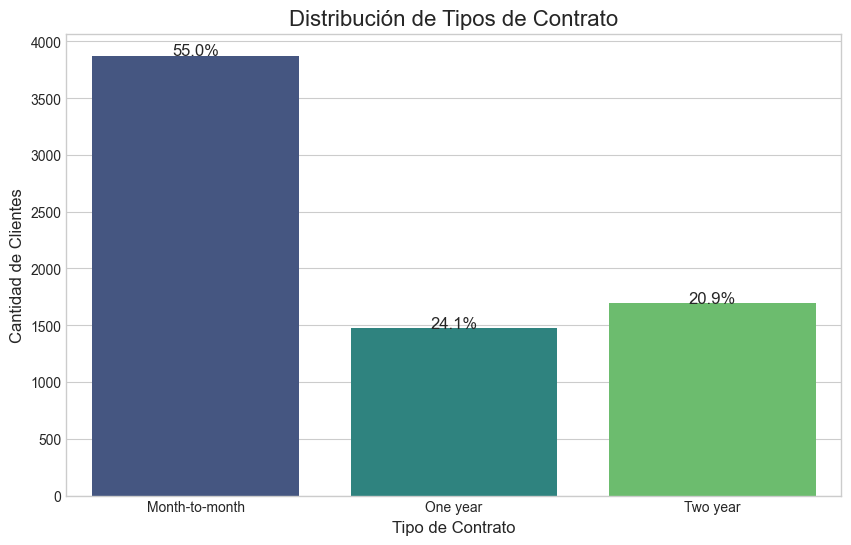

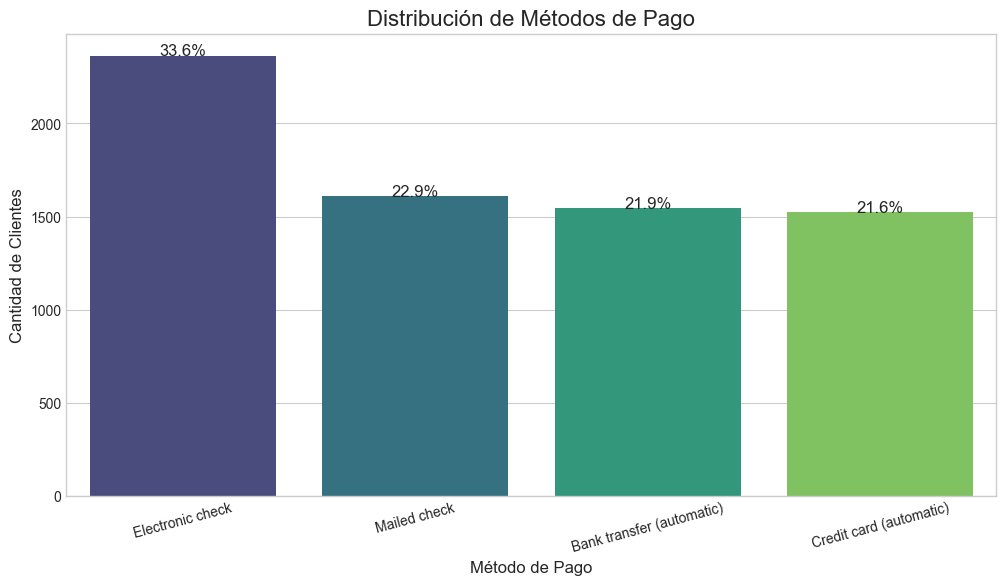

In [22]:
# Análisis exploratorio de patrones en los datos

# Verificamos la distribución de tipos de contrato
contract_distribution = df_contract['Type'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
sns.countplot(x='Type', data=df_contract, palette='viridis')
plt.title('Distribución de Tipos de Contrato', fontsize=16)
plt.xlabel('Tipo de Contrato', fontsize=12)
plt.ylabel('Cantidad de Clientes', fontsize=12)

# Añadir porcentajes en las barras
for i, p in enumerate(plt.gca().patches):
    height = p.get_height()
    plt.text(p.get_x() + p.get_width()/2.,
            height + 0.1,
            f'{contract_distribution.iloc[i]:.1f}%',
            ha="center", fontsize=12)

plt.show()

# Verificamos la distribución de métodos de pago
payment_distribution = df_contract['PaymentMethod'].value_counts(normalize=True) * 100

plt.figure(figsize=(12, 6))
sns.countplot(x='PaymentMethod', data=df_contract, palette='viridis')
plt.title('Distribución de Métodos de Pago', fontsize=16)
plt.xlabel('Método de Pago', fontsize=12)
plt.ylabel('Cantidad de Clientes', fontsize=12)
plt.xticks(rotation=15)

# Añadir porcentajes en las barras
for i, p in enumerate(plt.gca().patches):
    height = p.get_height()
    plt.text(p.get_x() + p.get_width()/2.,
            height + 0.1,
            f'{payment_distribution.iloc[i]:.1f}%',
            ha="center", fontsize=12)

plt.show()

### Verificación de Supuestos e Hipótesis

A continuación, realizaremos un análisis exploratorio para verificar las hipótesis planteadas anteriormente. Primero, necesitamos unificar los datos para tener una visión integral de los clientes.

In [23]:
# Unimos los datasets para análisis integral
df_merged = df_contract.merge(df_personal, on='customerID', how='left')
df_merged = df_merged.merge(df_internet, on='customerID', how='left')
df_merged = df_merged.merge(df_phone, on='customerID', how='left')

print(f"Dimensiones del dataset unificado: {df_merged.shape}")
print("\nPrimeras filas del dataset unificado:")
display(df_merged.head())

Dimensiones del dataset unificado: (7043, 20)

Primeras filas del dataset unificado:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
